In [1]:
from torch_geometric.datasets import Planetoid
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]  # Get the first (and only) graph

print("Cora Dataset Info:")
print("==================")
print(f"Number of nodes: {data.num_nodes}")      # 2,708 nodes (papers)
print(f"Number of edges: {data.num_edges}")      # 5,429 edges (citations)
print(f"Number of features: {data.num_features}") # 1,433 (bag-of-words)
print(f"Number of classes: {dataset.num_classes}") # 7 (paper topics)
print(f"Has isolated nodes: {data.has_isolated_nodes()}") # False
print(f"Has self-loops: {data.has_self_loops()}") # False

Cora Dataset Info:
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
Has isolated nodes: False
Has self-loops: False


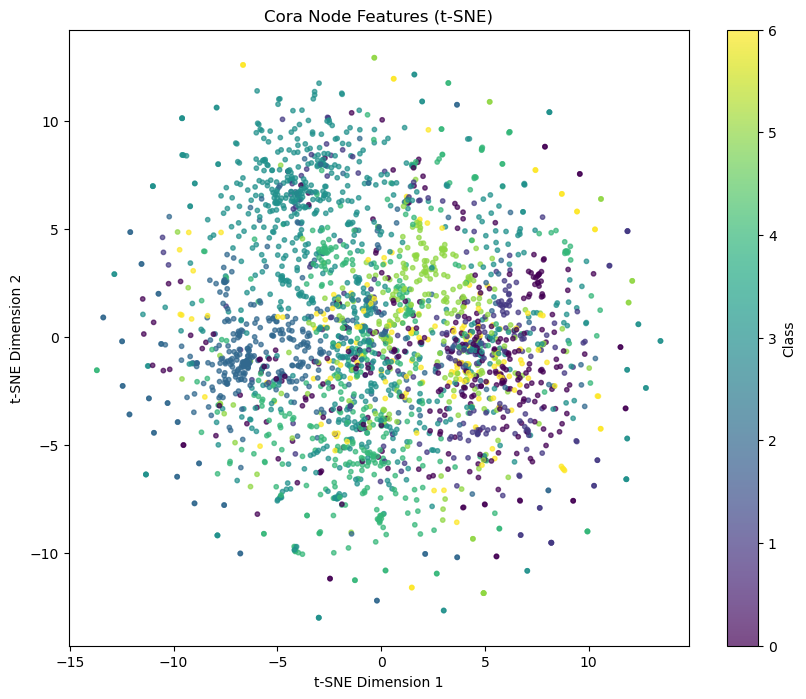

In [2]:
# Use t-SNE for non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
node_features_2d = tsne.fit_transform(data.x.numpy())

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    node_features_2d[:, 0],
    node_features_2d[:, 1],
    c=data.y.numpy(),
    cmap='viridis',
    alpha=0.7,
    s=10
)
plt.colorbar(scatter, label='Class')
plt.title("Cora Node Features (t-SNE)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

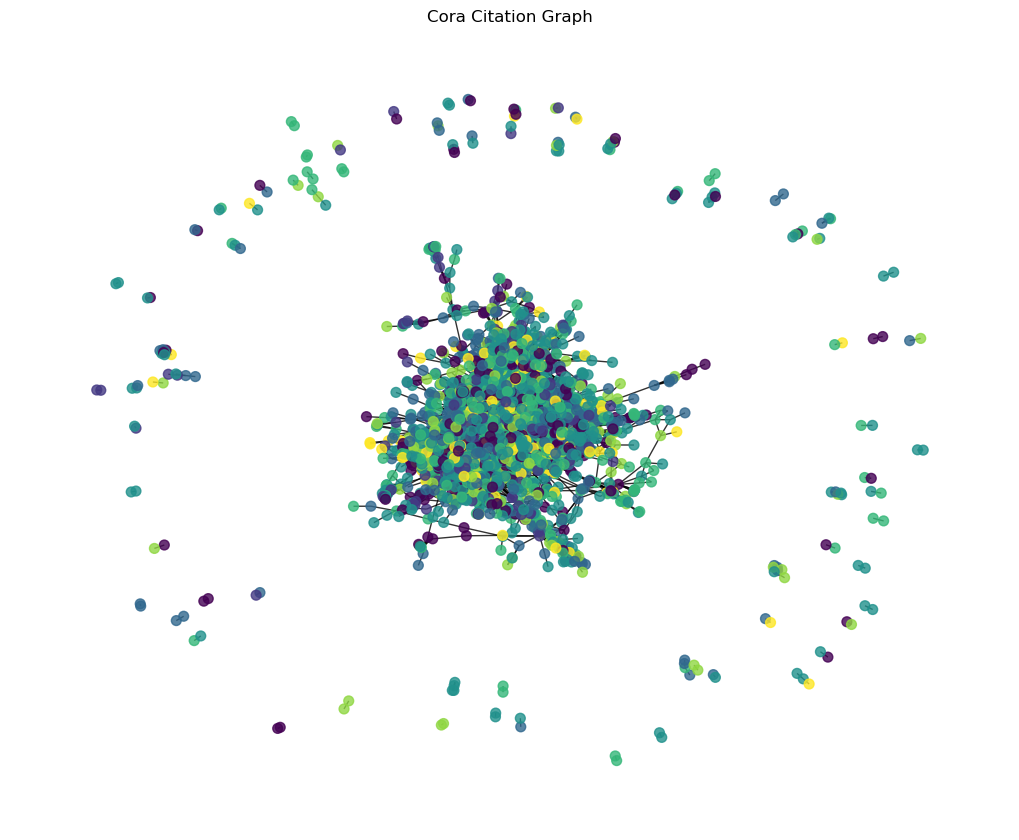

In [3]:
# Convert PyG graph to NetworkX (for visualization)
edge_index = data.edge_index.numpy()
G = nx.Graph()
G.add_edges_from([(edge_index[0][i], edge_index[1][i]) for i in range(edge_index.shape[1])])


plt.figure(figsize=(10, 8))
nx.draw(
    G,
    pos=nx.spring_layout(G, seed=42),
    node_size=50,
    node_color=data.y.numpy(),
    cmap='viridis',
    with_labels=False,
    alpha=0.8
)
plt.title("Cora Citation Graph")
plt.show()

# Prepare training and validation data

Cora is already split into training and validation sets (`data.train_mask`, `data.test_mask`).
For demonstation purposes, we'll use smaller sets and TSNE embeddings, not original features

**Construct a relationship matrix from edges**

In [4]:
from typing import Final
import numpy as np

n_nodes: Final[int] = len(data.x)
r_full = np.eye(n_nodes)

for i, j in data.edge_index.T:
    r_full[i, j] = r_full[j, i] = 1

**Construct a reduced dataset**

In [5]:
from tabrel.dataset import QueryUniqueBatchDataset

n_train: Final[int] = 500
n_test: Final[int] = n_train
data_full = QueryUniqueBatchDataset(x=node_features_2d, y=data.y, r=r_full, query_size=n_train, batch_size=n_test, n_batches=1, random_state=42)
for x_train, y_train, x_test, y_test, r_train_test in data_full:
    break

r_train = r_train_test[:n_train, :n_train]
r_test_inter = r_train_test[n_train:, :n_train]
r_test_intra = r_train_test[n_train:, n_train:]

# Train classifiers

In [6]:
from tabrel.sklearn_interface import TabRelClassifier
from tabrel.utils.config import ProjectConfig, ClassifierConfig, TrainingConfig

for rel in (True, False):  # using or not using relationships
    config = ProjectConfig(
        model=ClassifierConfig(
            n_features=x_train.shape[1],
            d_embedding=32,
            d_model=32,
            nhead=4,
            dim_feedforward=64,
            num_layers=2,
            num_classes=len(np.unique(data_full.y)),
            activation="relu",
            rel=rel,
            dropout=.1,
        ),
        training=TrainingConfig.default()
    )

    classifier = TabRelClassifier(config)
    classifier.fit(X=x_train, y=y_train, r=r_train)
    y_test_pred = classifier.predict(X=x_test, r_inter=r_test_inter, r_intra=r_test_intra)
    acc = (y_test - y_test_pred == 0).sum().item() / n_test
    print(f"acc={acc:.3f}, rel={rel}")

/Users/vzuev/Documents/git/gh_zuevval/tabrel/src/tabrel/sklearn_interface.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y, dtype=torch.long)


acc=0.438, rel=True
acc=0.416, rel=False
